<a href="https://colab.research.google.com/github/diegoturenne/Application-Oriented-Deep-Learning-Course-2022-UU/blob/main/Exercise_7_5a_Image_Segmentation_DT_FD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7.5a Image segmentation with a U-Net architecture

In this exercise you train an image segmentation model from scratch on the Oxford Pets dataset.
https://www.robots.ox.ac.uk/~vgg/data/pets/

## Download the data

In [ ]:
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2022-10-28 18:28:46--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2022-10-28 18:28:46--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz.2’

images.tar.gz.2     100%[===================>] 755.23M   195MB/s    in 3.9s    

2022-10-28 18:28:50 (196 MB/s) - ‘images.tar.gz.2’ saved [791918971/791918971]

--2022-10-28 18:28:50--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations

## Prepare paths of input images and target segmentation masks

you don't need to touch the code below. It creates lists of the filenames to the images and segmentation maps. 

In [ ]:
import os

input_dir = "images/"
target_dir = "annotations/trimaps/"
img_size = (160, 160) # all images get downscaled to this resolution
num_classes = 3
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


## What does one input image and corresponding segmentation mask look like?
The codeblock below shows how you can display the images and the target segmentation mask. To reduce the computing load, we will downscale all images to a size of 160x160 pixels as defined above. 
The goal of this task is to predict the segmentation mask as precisely as possible.

This example uses a few libraries to display and modify images (e.g. to rescale them to 160x160 pixels). The code below shows how these libraries can be used. 

image number 2


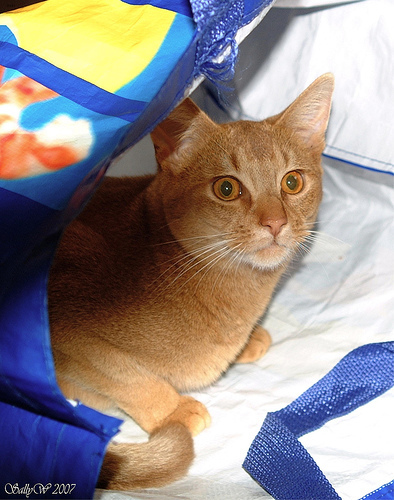

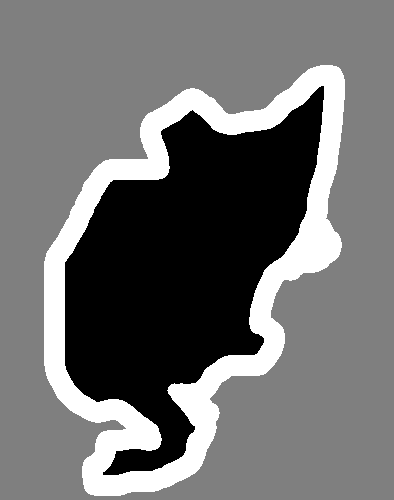

image number 2 downscaled.


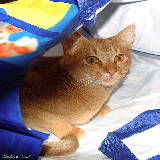

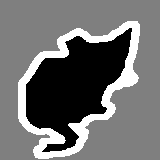

image number 7


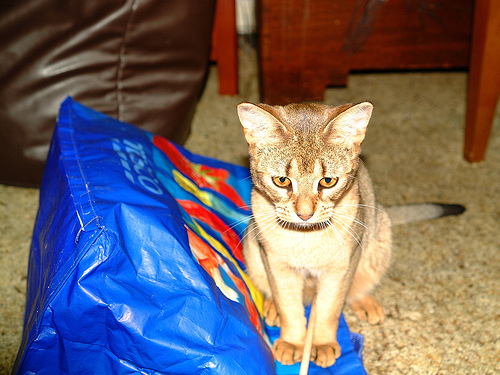

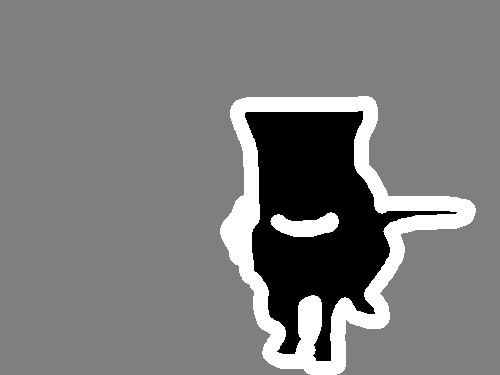

image number 7 downscaled.


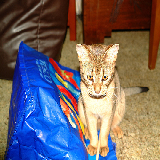

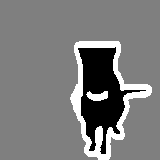

image number 3777


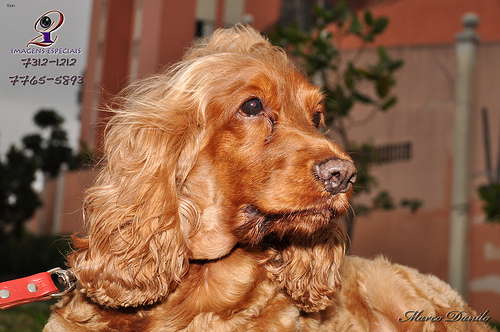

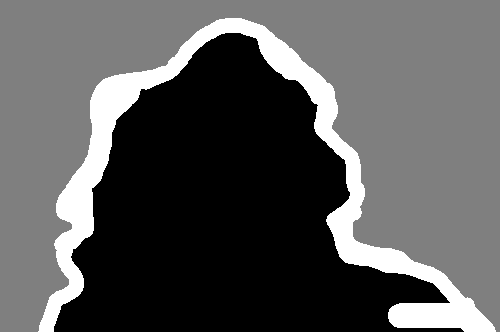

image number 3777 downscaled.


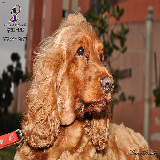

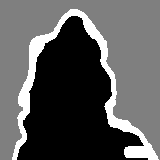

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps
import numpy as np

# Display input image #2 and #7
for i_sample in [2,7, 3777]:
  print(f"image number {i_sample}")
  display(Image(filename=input_img_paths[i_sample]))

  # Display auto-contrast version of corresponding target (per-pixel categories)
  # all pixels have either the value 1, 2 or 3:
  # 1: Foreground 2:Background 3: Not classified
  img =load_img(target_img_paths[i_sample])
  display(PIL.ImageOps.autocontrast(img)) # to properly display the image, we set an autocontrast (otherwise the values 1,2,3 would just all be black)
  
  print(f"image number {i_sample} downscaled.")
  # the task is done on a downscaled version of the image
  # the downscaling can be achieved by just passing a `targer_size` argument to the `load_img` function
  display(load_img(input_img_paths[i_sample], target_size=img_size))
  img = load_img(target_img_paths[i_sample], target_size=img_size)
  display(PIL.ImageOps.autocontrast(img))

## Prepare `Sequence` class to load & vectorize batches of data
You do not need to touch the codeblock below. It is a helper class that returns batches of images and their target masks in the downscaled version. This is an alternative way to provide the training and validation data to the KERAS fit function. A large library of images are typically too big too keep them all in memory. Instead, a so-called "generator" function returns a new batch of images everytime it is called. This is implemented below. When the `__get_item(idx)` method is called, it loads all images from batch `idx` into memory and returns it as a NumPy array. 
The `__len__` method returns how many batches are in one epoch.

In [ ]:
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPets(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2) # one hot encoding: 
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            # i.e. background is 0, foreground (the animal) is 1, and unclassified is 3 (the contour around the animal)
            y[j] -= 1
        return x, y


## Prepare U-Net model

Hints: 
* The final layer should have three feature maps with a softmax activation. This is because we want to predict the segmentation mask wich has three possible values: 0, 1, 2. The softmax activation works on each pixel, i.e., per pixel, the values of the feature maps add up to 1. Per pixel, the feature map with the highest propability indicates if we have "background", "foreground" or "unclassified". By using the `numpy.argmax` function, we can get back the integer for plotting the mask later (see `display_mask` function defined curther below).
* instead of using standard convolutions you can use `SeparableConv2D` to reduce the number of trainable parameters
* layers `x` and `x2` can be concacenated via `x = layers.concatenate([x, x2])`
* upsampling can be done with `x = layers.UpSampling2D(2)(x)`
* Always use `padding="same"` to keep the spatial dimension constant


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

x = 0 

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()


# TODO: define a network with the UNet architecture below. 
inputs = keras.Input(shape=img_size + (3,))

### [First half of the network: downsampling inputs] ###

# Entry block: start by adding a convolution layer. 
x = layers.Conv2D(32, 3, padding="same")(inputs)
x = layers.BatchNormalization()(x) # using batch normalization after the convolution but before the activation function can help. 
x = layers.Activation("relu")(x)

#TODO: Implement a UNet architecture here

#down (160 -> 80 px image)
x2 = layers.MaxPooling2D((2,2))(x) 

x2 = layers.SeparableConv2D(64, 3, padding="same")(x2)
x2 = layers.BatchNormalization()(x2) 
x2 = layers.Activation("relu")(x2)


#down (80 -> 40 px image)
x3 = layers.MaxPooling2D((2,2))(x2) 

x3 = layers.SeparableConv2D(128, 3, padding="same")(x3)
x3 = layers.BatchNormalization()(x3) 
x3 = layers.Activation("relu")(x3)


#down (40 -> 20 px image)
x4 = layers.MaxPooling2D((2,2))(x3) 

x4 = layers.SeparableConv2D(256, 3, padding="same")(x4)
x4 = layers.BatchNormalization()(x4) 
x4 = layers.Activation("relu")(x4)


#down (20 -> 10 px image)
x5 = layers.MaxPooling2D((2,2))(x4) 

x5 = layers.SeparableConv2D(512, 3, padding="same")(x5)
x5 = layers.BatchNormalization()(x5) 
x5 = layers.Activation("relu")(x5)

x5 = layers.SeparableConv2D(512, 3, padding="same")(x5)
x5 = layers.BatchNormalization()(x5) 
x5 = layers.Activation("relu")(x5)



#up 10 -> 20
u6 = layers.UpSampling2D(2)(x5)
u6 = layers.concatenate([x4, u6])

u6 = layers.SeparableConv2D(256, 3, padding="same")(u6)
u6 = layers.BatchNormalization()(u6) 
u6 = layers.Activation("relu")(u6)


## up 20px -> 40px  
u7 = layers.UpSampling2D(2)(u6)
u7 = layers.concatenate([x3, u7])

u7 = layers.SeparableConv2D(128, 3, padding="same")(u7)
u7 = layers.BatchNormalization()(u7) 
u7 = layers.Activation("relu")(u7)


## up 40px -> 80px  
u8 = layers.UpSampling2D(2)(u7)
u8 = layers.concatenate([x2, u8])

u8 = layers.SeparableConv2D(64, 3, padding="same")(u8)
u8 = layers.BatchNormalization()(u8) 
u8 = layers.Activation("relu")(u8)



## up 40px -> 80px  
u9 = layers.UpSampling2D(2)(u8)
u9 = layers.concatenate([x, u9])

u9 = layers.SeparableConv2D(32, 3, padding="same")(u9)
u9 = layers.BatchNormalization()(u9) 
u9 = layers.Activation("relu")(u9)

u9 = layers.SeparableConv2D(16, 3, padding="same")(u9)
u9 = layers.BatchNormalization()(u9) 
u9 = layers.Activation("relu")(u9)

# x=x3


# Add a per-pixel classification layer
outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(u9)

# Define the model
model = keras.Model(inputs, outputs)
 
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 160, 160, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 160, 160, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

## Set aside a validation split

In [ ]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiate data Sequences for each split
train_gen = OxfordPets(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)

## Train the model

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile( 
    # optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3),
    optimizer=keras.optimizers.Adadelta(learning_rate=0.5, epsilon=1e-2), ## too damn slow 
    metrics=["sparse_categorical_accuracy"], 
    loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Train the model, doing validation at the end of each epoch.
epochs = 15
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/15
199/199 [==============================] - 98s 464ms/step - loss: 0.6821 - sparse_categorical_accuracy: 0.7214 - val_loss: 0.9044 - val_sparse_categorical_accuracy: 0.5844
Epoch 2/15
199/199 [==============================] - 92s 463ms/step - loss: 0.4990 - sparse_categorical_accuracy: 0.8025 - val_loss: 0.6979 - val_sparse_categorical_accuracy: 0.6992
Epoch 3/15
199/199 [==============================] - 92s 462ms/step - loss: 0.4474 - sparse_categorical_accuracy: 0.8236 - val_loss: 0.4787 - val_sparse_categorical_accuracy: 0.8121
Epoch 4/15
199/199 [==============================] - 93s 465ms/step - loss: 0.4140 - sparse_categorical_accuracy: 0.8371 - val_loss: 0.4764 - val_sparse_categorical_accuracy: 0.8152
Epoch 5/15
199/199 [==============================] - 92s 461ms/step - loss: 0.3907 - sparse_categorical_accuracy: 0.8461 - val_loss: 0.4404 - val_sparse_categorical_accuracy: 0.8320
Epoch 6/15
199/199 [==============================] - 92s 462ms/step - loss: 0.3736 -

## Visualize predictions

In [ ]:
# Generate predictions for all images in the validation set
model.load_weights("oxford_segmentation.h5") # the last iteration might not be the best. So load back the best version
val_gen = OxfordPets(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1) # find which feature map has the highest value per pixel -> this gives back the category 0, 1, or 2
    mask = np.expand_dims(mask, axis=-1) # The image plotting library requires that the color of the image is given as an array (in our case it is just one number, but for color images we would have three color channels)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


31/31 [==============================] - 5s 161ms/step


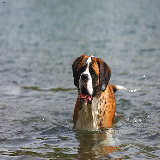

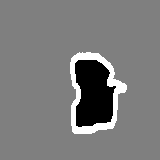

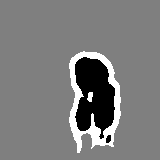

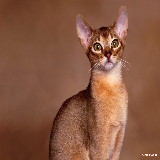

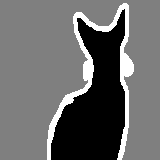

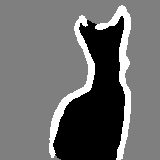

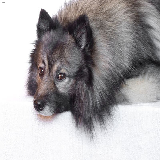

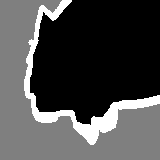

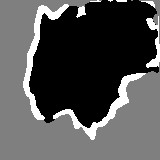

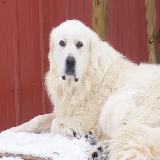

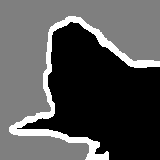

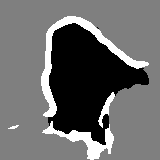

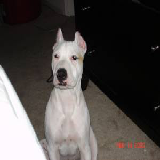

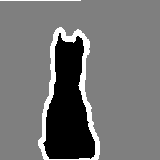

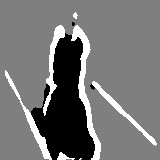

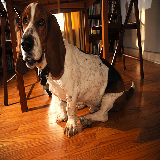

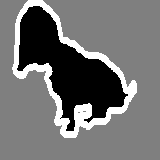

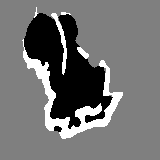

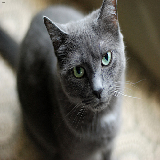

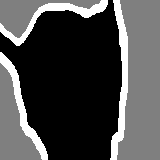

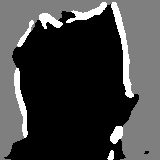

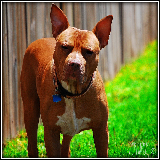

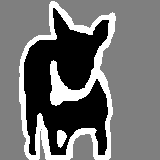

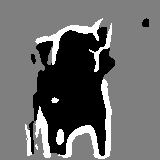

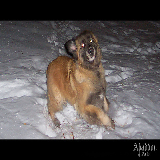

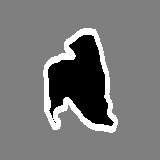

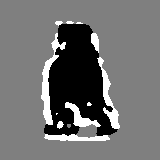

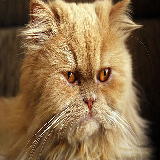

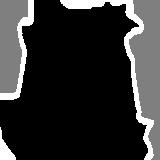

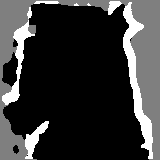

In [ ]:
# Display results for validation image #10
for i in range(10):

  # Display input image
  display(load_img(val_input_img_paths[i], target_size=img_size))

  # Display ground-truth target mask
  img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i], target_size=img_size))
  display(img)

  # Display mask predicted by our model
  display_mask(i)  # Note that the model only sees inputs at 160x160.